# Seminar 4: SVM

Today we are going to implement SVM on pytorch

In [13]:
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

import numpy as np
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

First let's create toy separable dataset 

In [14]:
X, Y = make_blobs(n_samples=300, centers=2, random_state=45, cluster_std=0.6)
Y[Y == 0] = -1 # for convenience with formulas

And polt it.

It's a separable problem

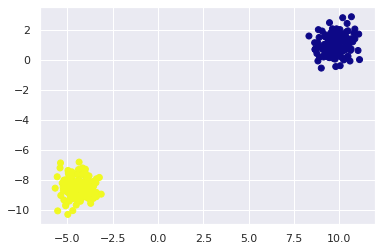

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='plasma')

## Support Vector Machines theory

Linear SVM __primal__ optimization problem can be formulated as

$$ \frac{1}{n} \sum_{i=1}^n \max(0, 1 - y_i (w X_i - b)) + \lambda ||w||_2 \to \min_w $$

This problem can be solved with gradient or sub-gradien methods.

-----
Whereas __dual__ optimization problem formulates as follows:

$$
\sum_{i=1}^n c_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n y_i c_i (X_i \cdot X_j ) y_j c_j \to \max_{c_1,...,c_n} \\ \text{subject to} \\
\sum_{i=1}^n c_iy_i=0 \\
0 \leq c_i \leq \frac{1}{2n\lambda} \forall i
$$

Where $W = \sum_{i=1}^n c_i y_i X_i$.

In this quadratic optimization problem we can use kernel trick: <br/>
introduce fucntion $K(X_i, X_j) = \phi (X_i) \phi (X_j)$ and change dot products in our optimization problem

Then we have 

$$
\sum_{i=1}^n c_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n y_i c_i K(X_i, X_j) y_j c_j \to \max_{c_1,...,c_n} \\
\text{subject to} \\
\sum_{i=1}^n c_iy_i=0 \\
0 \leq c_i \leq \frac{1}{2n\lambda} \forall i
$$

$W = \sum_{i=1}^n c_i y_i \phi(X_i)$

In quadratic programming we can straightforwardly add kernel function, but it is not that simple, if we want to use gradient algorithms.

----
However primal optimization problem with kernels can be formulated like (see [Olivier Chapelle, 2006](https://www.cs.utah.edu/~piyush/teaching/svm-solving-primal.pdf)):

$$f(x) = \sum_{i=1}^n \beta_i K(x_i, x)$$

$$K: K_{i,j} = K(x_i, x_j)$$

$$ \lambda \vec{\beta^T} K \vec{\beta} + \sum_{i=1}^n L(y_i, K_i^T \vec{\beta}) \to \min_{\vec{\beta}}$$

where L is Hinge loss: $L(y_i, K_i^T \vec{\beta}) = \max(0, 1 - y_i (K_i^T \vec{\beta}))$

## For brave and true: SVM implementation with SGD

Let's code SVM with primal optimization problem and kernels on pytorch

Some parts were taken from [this notebook](https://github.com/nikhilraghava/PyTorch-SVM/blob/master/SVM%20-%20PyTorch.ipynb) 

In [16]:
def hinge_loss(scores, labels):
    '''Mean loss for batch of objects
    '''
    assert len(scores.shape) == 1
    assert len(labels.shape) == 1
    return torch.clamp(1 - labels*scores, min=0).mean()


class SVM(BaseEstimator, ClassifierMixin):
    @staticmethod
    def linear(x_1, x_2):
        '''Computes linear kernel for batches of objects
        
        Args:
            x_1: array shaped `(#samples_1, #features)`
            x_2: array shaped `(#samples_2, #features)`
        Returns:
            kernel function values for all pairs of samples from x_1 and x_2
            shaped `(#samples_1, #samples_2)`
        '''
        return x_1 @ x_2.T
    
    def __init__(
        self,
        lr: float=1e-3,
        epochs: int=2,
        batch_size: int=64,
        lmbd: float=1e-4,
        kernel_function=None,
        verbose: bool=False,
    ):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lmbd = lmbd
        self.kernel_function = kernel_function or SVM.linear
        self.verbose = verbose
        self.fitted = False

    def __repr__(self):
        return 'SVM model, fitted: {self.fitted}'

    def fit(self, X, Y):
        assert (np.abs(Y) == 1).all()
        n_obj = len(X)
        X, Y = torch.FloatTensor(X), torch.FloatTensor(Y)
        K = self.kernel_function(X, X).float()

        self.betas = torch.full((n_obj, 1), fill_value=0.001, dtype=X.dtype, requires_grad=True)
        self.bias = torch.zeros(1, requires_grad=True) # I've also add bias to the model
        
        optimizer = optim.SGD((self.betas, self.bias), lr=self.lr)
        for epoch in range(self.epochs):
            perm = torch.randperm(n_obj)  # Generate a set of random numbers of length: sample size
            sum_loss = 0.                 # Loss for each epoch
            for i in range(0, n_obj, self.batch_size):
                batch_inds = perm[i:i + self.batch_size]
                x_batch = X[batch_inds]   # Pick random samples by iterating over random permutation
                y_batch = Y[batch_inds]   # Pick the correlating class
                k_batch = K[batch_inds]
                
                optimizer.zero_grad()     # Manually zero the gradient buffers of the optimizer
                
                preds = k_batch @ self.betas + self.bias### YOUR CODE HERE # Compute the output by doing a forward pass
                preds = preds.flatten()
                loss = self.lmbd * self.betas[batch_inds].T @ k_batch @ self.betas + hinge_loss(preds, y_batch)
                loss.backward()           # Backpropagation
                optimizer.step()          # Optimize and adjust weights

                sum_loss += loss.item()   # Add the loss

            if self.verbose: print("Epoch " + str(epoch) + ", Loss: " + str(sum_loss / self.batch_size))

        self.X = X
        self.fitted = True
        return self

    def predict_scores(self, batch):
        with torch.no_grad():
            batch = torch.from_numpy(batch).float()
            K = self.kernel_function(batch, self.X)
            return (K @ self.betas + self.bias).flatten()### YOUR CODE HERE

    def predict(self, batch):
        scores = self.predict_scores(batch)
        answers = np.full(len(batch), -1, dtype=np.int64)
        answers[scores > 0] = 1
        return answers

In [17]:
model = SVM(epochs=2, verbose=True)
model.fit(X, Y)
predictions = model.predict(X)
accuracy_score(Y, predictions)

Epoch 0, Loss: 0.0758733709808439
Epoch 1, Loss: 0.015692066866904497


1.0

So, our model works and has 100% accuracy on train data.

(If not - try to restart training, SGD is unstable)

## Playing with `sklearn`'s implementation

[original post](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

In [18]:
from sklearn.svm import SVC # "Support vector classifier"

In [19]:
model = SVC(kernel='linear', C=1e10)
model.fit(X, Y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [20]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

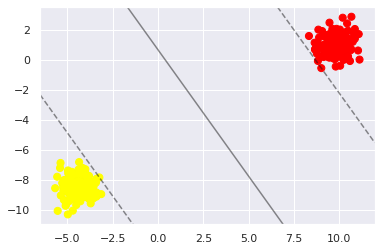

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [22]:
model.support_vectors_

array([[ 9.01725068, -0.56723264],
       [-3.23676301, -7.84961627]])

### Example with kernel from sklearn

In [23]:
from sklearn.datasets import make_circles

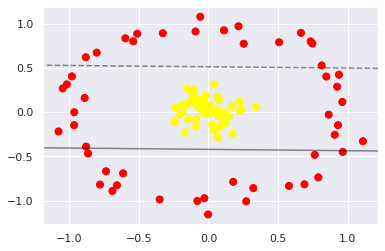

In [24]:
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [25]:
r = np.exp(-(X ** 2).sum(1))

In [26]:
clf = SVC(kernel='rbf', C=1e6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

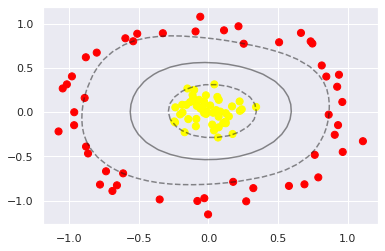

In [27]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### Different margins for nonseparable cases

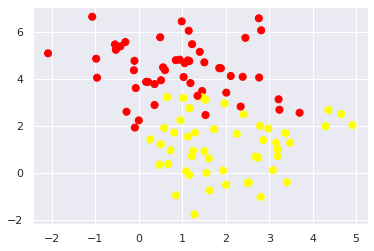

In [28]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

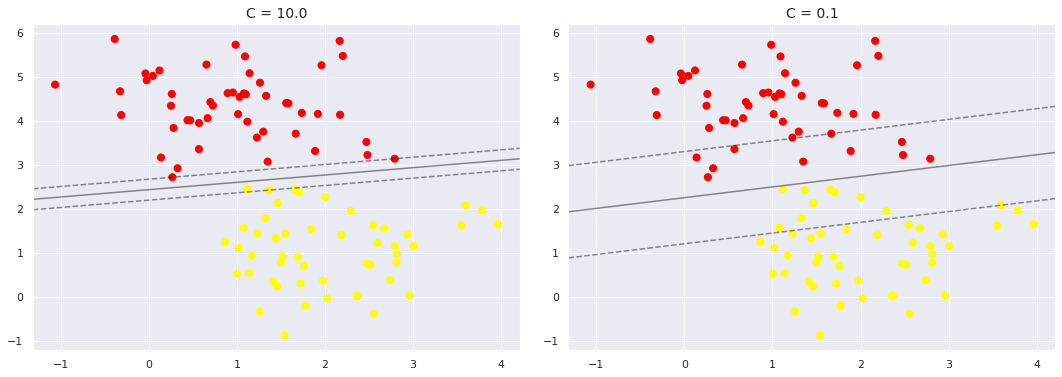

In [29]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Next step is to write own Regression model using Support Vectors. [Here is the idea](https://stats.stackexchange.com/questions/82044/how-does-support-vector-regression-work-intuitively)